
# Modelo Híbrido CNN-LSTM - VALE3.SA

**Objetivo:** Este notebook implementa e avalia um modelo híbrido otimizado, combinando Redes Neurais Convolucionais 1D (CNN 1D) e Redes Neurais Recorrentes (LSTM), para prever a tendência (Compra/Venda) da ação VALE3.SA. O modelo utiliza features numéricas e hiperparâmetros ajustados.

**Contexto:** Aplicação da arquitetura CNN-LSTM como parte do desafio da Cartesius Capital.

**Metodologia:**
1.  **Carregamento e Pré-processamento:** Utilização dos dados e pipeline de pré-processamento definidos na Análise Exploratória de VALE3.SA (incluindo cálculo de BBands).
2.  **Modelo Híbrido CNN-LSTM:** Construção do modelo sequencial CNN-LSTM com hiperparâmetros ajustados (`dropout=0.4`, `learning_rate=0.001`).
3.  **Treinamento:** Treinamento do modelo com os dados de treino da VALE3.SA, balanceamento de classes e Early Stopping.
4.  **Avaliação:** Análise detalhada do desempenho no conjunto de teste da VALE3.SA.
5.  **Visualização:** Geração de gráficos para análise dos resultados.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
# Importar camadas necessárias: Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam # Usando legacy Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.utils import class_weight
import os
import time

# Configurações básicas
plt.style.use('fivethirtyeight')
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [15, 7] # Tamanho padrão dos gráficos

# --- Configuração do Dispositivo ---
print("Configurando dispositivo TensorFlow...")
try:
    if tf.config.list_physical_devices('GPU'):
        print("GPU disponível. Usando TensorFlow com GPU.")
    elif hasattr(tf.config, 'list_physical_devices') and tf.config.list_physical_devices('MPS'):
         print("Apple MPS disponível. Usando TensorFlow com MPS.")
    else:
        print("Nenhuma GPU ou MPS detectada. Usando TensorFlow em CPU.")
except Exception as e:
    print(f"Erro ao configurar dispositivos: {e}. Usando configuração padrão.")

Configurando dispositivo TensorFlow...
GPU disponível. Usando TensorFlow com GPU.



## 1. Carregamento dos Dados

Carregamos os arquivos `treino.csv` e `teste.csv` para a ação VALE3.SA.


In [2]:
# Define o ticker
STOCK_TICKER = "VALE3.SA"
STOCK_NAME = "Vale"
DATA_DIR = os.path.join('../data', STOCK_TICKER)
TRAIN_PATH = os.path.join(DATA_DIR, 'treino.csv')
TEST_PATH = os.path.join(DATA_DIR, 'teste.csv')

print(f"Verificando dados para: {STOCK_TICKER}")
# Verifica se os diretórios e arquivos existem
if not os.path.exists(DATA_DIR):
    print(f"ERRO: Diretório de dados não encontrado em '{DATA_DIR}'")
elif not os.path.exists(TRAIN_PATH):
    print(f"ERRO: Arquivo de treino não encontrado em '{TRAIN_PATH}'")
elif not os.path.exists(TEST_PATH):
    print(f"ERRO: Arquivo de teste não encontrado em '{TEST_PATH}'")
else:
    try:
        df_train_raw = pd.read_csv(TRAIN_PATH, index_col='Date', parse_dates=True)
        df_test_raw = pd.read_csv(TEST_PATH, index_col='Date', parse_dates=True)
        print(f"Dados de treino ({STOCK_TICKER}) carregados. Shape: {df_train_raw.shape}")
        print(f"Dados de teste ({STOCK_TICKER}) carregados. Shape: {df_test_raw.shape}")

        if 'Unnamed: 0' in df_train_raw.columns: df_train_raw = df_train_raw.drop(columns=['Unnamed: 0'])
        if 'Unnamed: 0' in df_test_raw.columns: df_test_raw = df_test_raw.drop(columns=['Unnamed: 0'])

    except Exception as e:
        print(f"Erro ao carregar os dados para {STOCK_TICKER}: {e}")

# Exibe as primeiras linhas do treino
if 'df_train_raw' in locals():
    print("\n--- Amostra Dados Treino ---")
    print(df_train_raw.head())
else:
    print("\nNão foi possível carregar os dados de treino.")

Verificando dados para: VALE3.SA
Dados de treino (VALE3.SA) carregados. Shape: (4808, 19)
Dados de teste (VALE3.SA) carregados. Shape: (1203, 19)

--- Amostra Dados Treino ---
               Close  Smoothed_Close  Label  Past_1_Days_Close  \
Date                                                             
2000-01-24  1.829122        1.752574      1           1.791015   
2000-01-25  1.829122        1.760229      1           1.829122   
2000-01-26  1.813879        1.765594      1           1.829122   
2000-01-27  1.829122        1.771947      1           1.813879   
2000-01-28  1.829122        1.777664      1           1.829122   

            Past_2_Days_Close  Past_3_Days_Close  Past_4_Days_Close  \
Date                                                                  
2000-01-24           1.829122           1.840554           1.848175   
2000-01-25           1.791015           1.829122           1.840554   
2000-01-26           1.829122           1.791015           1.829122   
2000-0


## 2. Engenharia de Features e Definição do Alvo

Aplicamos a mesma função de engenharia de features utilizada na EDA, que inclui o cálculo dos indicadores técnicos (SMA, EMA, MACD, RSI, ROC) e das Bandas de Bollinger, além da definição da variável alvo `signal`.


In [3]:
def calculate_features_and_target_adapted(df):
    """
    Calcula indicadores técnicos e a variável alvo 'signal'.
    """
    df_copy = df.copy(); price_col = 'Close'
    if price_col not in df_copy.columns: raise ValueError(f"Coluna '{price_col}' não encontrada.")
    if 'Label' not in df_copy.columns: raise ValueError("Coluna 'Label' (alvo) não encontrada.")

    # a) Indicadores Técnicos
    df_copy['daily_return'] = df_copy[price_col].pct_change() * 100
    for window in [5, 10, 20, 50]: df_copy[f'sma_{window}'] = df_copy[price_col].rolling(window=window, min_periods=1).mean()
    df_copy['ema_12'] = df_copy[price_col].ewm(span=12, adjust=False).mean(); df_copy['ema_26'] = df_copy[price_col].ewm(span=26, adjust=False).mean()
    df_copy['macd'] = df_copy['ema_12'] - df_copy['ema_26']; df_copy['macd_signal'] = df_copy['macd'].ewm(span=9, adjust=False).mean(); df_copy['macd_hist'] = df_copy['macd'] - df_copy['macd_signal']
    delta = df_copy[price_col].diff(); gain = delta.where(delta > 0, 0).fillna(0); loss = -delta.where(delta < 0, 0).fillna(0)
    avg_gain = gain.ewm(com=14 - 1, min_periods=14).mean(); avg_loss = loss.ewm(com=14 - 1, min_periods=14).mean()
    rs = avg_gain / avg_loss; df_copy['rsi'] = 100 - (100 / (1 + rs)); df_copy['rsi'] = df_copy['rsi'].fillna(50)
    for window in [5, 10, 20]: df_copy[f'roc_{window}'] = df_copy[price_col].pct_change(periods=window) * 100

    # Bandas de Bollinger
    bb_window = 20; bb_std_dev = 2
    if f'sma_{bb_window}' not in df_copy.columns: df_copy[f'sma_{bb_window}'] = df_copy[price_col].rolling(window=bb_window, min_periods=1).mean()
    std_dev_temp = df_copy[price_col].rolling(window=bb_window, min_periods=1).std()
    df_copy['bollinger_high'] = df_copy[f'sma_{bb_window}'] + (bb_std_dev * std_dev_temp)
    df_copy['bollinger_low'] = df_copy[f'sma_{bb_window}'] - (bb_std_dev * std_dev_temp)
    # df_copy = df_copy.drop(columns=['std_dev_temp']) # Não existe mais

    # b) Features de Retorno Histórico
    past_cols = [col for col in df_copy.columns if col.startswith('Past_') and col.endswith('_Close')]
    if past_cols:
        for col in past_cols:
            try: df_copy[f'return_{col}'] = (df_copy[price_col] / df_copy[col] - 1) * 100; df_copy[f'return_{col}'] = df_copy[f'return_{col}'].replace([np.inf, -np.inf], np.nan)
            except Exception as e: pass
    else: print("Colunas 'Past_X_Days_Close' não encontradas.")

    # c) Variável Alvo
    if df_copy['Label'].isin([1, -1]).all(): df_copy['signal'] = df_copy['Label'].map({1: 1, -1: 0})
    elif df_copy['Label'].isin([1, 0]).all(): df_copy['signal'] = df_copy['Label']
    else: raise ValueError(f"Valores inesperados na coluna 'Label': {df_copy['Label'].unique()}.")
    if 'Label' in df_copy.columns: df_copy = df_copy.drop(columns=['Label'])
    return df_copy

# Aplicar a função
if 'df_train_raw' in locals() and 'df_test_raw' in locals():
    print(f"\n--- Processando Treino ({STOCK_TICKER}) ---")
    df_train = calculate_features_and_target_adapted(df_train_raw)
    print(f"\n--- Processando Teste ({STOCK_TICKER}) ---")
    df_test = calculate_features_and_target_adapted(df_test_raw)
    print(f"\nEngenharia de features concluída para {STOCK_TICKER}.")
else:
    print("\nDataFrames não carregados. Engenharia de features não realizada.")


--- Processando Treino (VALE3.SA) ---

--- Processando Teste (VALE3.SA) ---

Engenharia de features concluída para VALE3.SA.



## 3. Tratamento de Valores Ausentes (NaNs)

Removemos as linhas com NaNs resultantes do cálculo dos indicadores.


In [4]:
if 'df_train' in locals() and 'df_test' in locals():
    print("Tratando NaNs após cálculo de features...")
    initial_train_rows = len(df_train); initial_test_rows = len(df_test)
    return_past_cols = [col for col in df_train.columns if col.startswith('return_Past_')]
    if return_past_cols:
        df_train[return_past_cols] = df_train[return_past_cols].fillna(0)
        df_test[return_past_cols] = df_test[return_past_cols].fillna(0)
    df_train.dropna(inplace=True); df_test.dropna(inplace=True)
    print(f"Linhas removidas do treino: {initial_train_rows - len(df_train)}, teste: {initial_test_rows - len(df_test)}")
    print(f"Shape treino final: {df_train.shape}, teste: {df_test.shape}")
    if df_train.empty or df_test.empty: raise RuntimeError("Erro: DataFrames vazios após dropna!")
    df_train['signal'] = df_train['signal'].astype(int); df_test['signal'] = df_test['signal'].astype(int)
else:
    print("\nDataFrames df_train ou df_test não definidos. Tratamento de NaNs não realizado.")

Tratando NaNs após cálculo de features...
Linhas removidas do treino: 20, teste: 20
Shape treino final: (4788, 49), teste: (1183, 49)



## 4. Seleção de Features e Preparação Final

Selecionamos as features (incluindo Bandas de Bollinger) e separamos os dados em X/y para treino e teste.


In [5]:
if 'df_train' in locals() and 'df_test' in locals():
    # Lista final de features
    feature_cols = [
        'daily_return', 'sma_5', 'sma_10', 'sma_20', 'sma_50', 'ema_12', 'ema_26',
        'macd', 'macd_signal', 'macd_hist', 'rsi', 'roc_5', 'roc_10', 'roc_20',
        'return_Past_1_Days_Close', 'return_Past_3_Days_Close', 'return_Past_5_Days_Close',
        'return_Past_10_Days_Close', 'return_Past_15_Days_Close', 'Close',
        'bollinger_high', 'bollinger_low' # Incluindo BBands
    ]
    target_col = 'signal'

    # Garantir que todas as features existem
    available_cols = df_train.columns.tolist() # Checa só no treino, teste deve ser igual
    feature_cols = sorted([col for col in feature_cols if col in available_cols])
    print(f"Features finais selecionadas ({len(feature_cols)}):\n{feature_cols}")

    # Verificar se o teste tem as mesmas colunas (importante)
    if not all(col in df_test.columns for col in feature_cols):
        missing_in_test = [col for col in feature_cols if col not in df_test.columns]
        raise ValueError(f"ERRO: Colunas faltando no df_test: {missing_in_test}")
    if target_col not in df_test.columns:
        raise ValueError(f"ERRO: Coluna target '{target_col}' faltando no df_test")

    # Separar X e y
    X_train = df_train[feature_cols]; y_train = df_train[target_col]
    X_test = df_test[feature_cols]; y_test = df_test[target_col]
    print(f"\nShapes finais: X_train {X_train.shape}, y_train {y_train.shape}, X_test {X_test.shape}, y_test {y_test.shape}")
else:
    print("\nDataFrames df_train ou df_test não definidos. Separação X/y não realizada.")

Features finais selecionadas (22):
['Close', 'bollinger_high', 'bollinger_low', 'daily_return', 'ema_12', 'ema_26', 'macd', 'macd_hist', 'macd_signal', 'return_Past_10_Days_Close', 'return_Past_15_Days_Close', 'return_Past_1_Days_Close', 'return_Past_3_Days_Close', 'return_Past_5_Days_Close', 'roc_10', 'roc_20', 'roc_5', 'rsi', 'sma_10', 'sma_20', 'sma_5', 'sma_50']

Shapes finais: X_train (4788, 22), y_train (4788,), X_test (1183, 22), y_test (1183,)



## 5. Pré-processamento: Escalonamento

Aplicamos o `MinMaxScaler`.


In [6]:
if 'X_train' in locals() and 'X_test' in locals():
    print("Aplicando escalonamento MinMaxScaler...")
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Escalonamento concluído.")
else:
    print("\nX_train ou X_test não definidos. Escalonamento não realizado.")

Aplicando escalonamento MinMaxScaler...
Escalonamento concluído.



## 6. Pré-processamento: Criação de Sequências Temporais

Transformamos os dados escalonados em sequências de `n_steps = 15` dias.


In [8]:
def create_sequences(X, y, n_steps):
    if len(X) < n_steps:
        n_features = X.shape[1] if X.ndim == 2 else 0
        return np.empty((0, n_steps, n_features)), np.empty((0,)), np.empty((0,), dtype=y.index.dtype)
    Xs, ys, y_indices = [], [], []
    for i in range(len(X) - n_steps + 1):
        end_ix = i + n_steps; Xs.append(X[i:end_ix]); ys.append(y.iloc[end_ix - 1]); y_indices.append(y.index[end_ix - 1])
    if not Xs:
        n_features = X.shape[1] if X.ndim == 2 else 0
        return np.empty((0, n_steps, n_features)), np.empty((0,)), np.empty((0,), dtype=y.index.dtype)
    return np.array(Xs), np.array(ys), np.array(y_indices)

if 'X_train_scaled' in locals() and 'y_train' in locals() and 'X_test_scaled' in locals() and 'y_test' in locals():
    n_steps = 15
    print(f"Criando sequências com n_steps = {n_steps}...")
    X_train_seq, y_train_seq, _ = create_sequences(X_train_scaled, y_train, n_steps)
    X_test_seq, y_test_seq, y_test_indices = create_sequences(X_test_scaled, y_test, n_steps)
    if X_train_seq.size == 0 or X_test_seq.size == 0: raise RuntimeError("Erro: Não foi possível criar as sequências.")
    print(f"Shapes sequenciais: X_train_seq {X_train_seq.shape}, y_train_seq {y_train_seq.shape}, X_test_seq {X_test_seq.shape}, y_test_seq {y_test_seq.shape}")
else:
    print("\nDados escalonados ou target não definidos. Criação de sequências não realizada.")

Criando sequências com n_steps = 15...
Shapes sequenciais: X_train_seq (4774, 15, 22), y_train_seq (4774,), X_test_seq (1169, 15, 22), y_test_seq (1169,)



## 7. Balanceamento de Classes

Calculamos os pesos de classe.


In [9]:
if 'y_train_seq' in locals():
    print("Calculando pesos das classes...")
    if len(y_train_seq) > 0 and len(np.unique(y_train_seq)) > 1:
        class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
        class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
        print(f"Pesos das classes calculados: {class_weight_dict}")
    else:
        print("Aviso: Não foi possível calcular pesos (y_train_seq vazio ou só uma classe).")
        class_weight_dict = None
else:
    print("\ny_train_seq não definido. Cálculo de pesos não realizado.")
    class_weight_dict = None # Garante que a variável existe

Calculando pesos das classes...
Pesos das classes calculados: {0: 0.8867013372956909, 1: 1.1464937560038424}



## 8. Construção do Modelo Híbrido CNN-LSTM - VALE3.SA

* CNN: Conv1D(64, 3) -> MaxPooling1D(2)
* LSTM: units=64, recurrent_dropout=0.1
* Final: Dropout(0.4) -> Dense(1, sigmoid)
* Otimizador: Adam Legacy (lr=0.001)


In [10]:
# Verifica se X_train_seq existe antes de construir
if 'X_train_seq' in locals() and X_train_seq.size > 0:
    print("Construindo o modelo híbrido CNN-LSTM para VALE3.SA...")
    n_features = X_train_seq.shape[2]
    n_steps = X_train_seq.shape[1] # Pega n_steps dos dados
    print(f"Input shape: ({n_steps}, {n_features})")

    # --- Hiperparâmetros (Ajustados para VALE3) ---
    N_FILTERS = 64
    KERNEL_SIZE = 3
    POOL_SIZE = 2
    LSTM_UNITS = 64
    DROPOUT_RATE = 0.4
    LEARNING_RATE = 0.001

    model = Sequential(name="CNN_LSTM_VALE3_SA") # Nome dinâmico
    model.add(Input(shape=(n_steps, n_features)))
    model.add(Conv1D(filters=N_FILTERS, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv1d_1'))
    model.add(MaxPooling1D(pool_size=POOL_SIZE, name='maxpool1d'))
    model.add(LSTM(units=LSTM_UNITS, recurrent_dropout=0.1, name='lstm_layer'))
    model.add(Dropout(DROPOUT_RATE, name='dropout_final'))
    model.add(Dense(1, activation='sigmoid', name='output'))
    model.summary()

    print("\nCompilando o modelo...")
    model.compile(
        optimizer=LegacyAdam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    print("Modelo compilado.")
else:
    print("\nX_train_seq não definido ou vazio. Modelo não construído.")

Construindo o modelo híbrido CNN-LSTM para VALE3.SA...
Input shape: (15, 22)


2025-04-26 13:03:50.243451: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-26 13:03:50.243645: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-26 13:03:50.243662: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-26 13:03:50.243989: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-26 13:03:50.244529: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "CNN_LSTM_VALE3_SA"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 15, 64)            4288      
                                                                 
 maxpool1d (MaxPooling1D)    (None, 7, 64)             0         
                                                                 
 lstm_layer (LSTM)           (None, 64)                33024     
                                                                 
 dropout_final (Dropout)     (None, 64)                0         
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 37377 (146.00 KB)
Trainable params: 37377 (146.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Compilando


## 9. Treinamento do Modelo - VALE3.SA

Treinamos o modelo CNN-LSTM com os dados de VALE3.SA.


In [11]:
# Verifica se o modelo e os dados existem
if 'model' in locals() and 'X_train_seq' in locals() and 'y_train_seq' in locals() and 'X_test_seq' in locals() and 'y_test_seq' in locals():
    EPOCHS = 64
    BATCH_SIZE = 64
    early_stopping = EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True, verbose=1)

    print(f"Iniciando o treinamento para {STOCK_TICKER} por até {EPOCHS} épocas...")
    start_time = time.time()
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        class_weight=class_weight_dict, # Usa os pesos calculados
        verbose=1
    )
    end_time = time.time()
    print(f"Treinamento concluído em {(end_time - start_time)/60:.2f} minutos.")
else:
    print("\nModelo ou dados de sequência não definidos. Treinamento não realizado.")
    history = None # Garante que history existe para a próxima célula

Iniciando o treinamento para VALE3.SA por até 64 épocas...
Epoch 1/64


2025-04-26 13:04:00.743426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.6491 - auc: 0.7290

2025-04-26 13:04:11.204437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 12s 137ms/step - loss: 0.6156 - accuracy: 0.6491 - auc: 0.7290 - val_loss: 0.9697 - val_accuracy: 0.5526 - val_auc: 0.8190
Epoch 2/64
75/75 [==============================] - 10s 127ms/step - loss: 0.4946 - accuracy: 0.7589 - auc: 0.8480 - val_loss: 0.4665 - val_accuracy: 0.7776 - val_auc: 0.8980
Epoch 3/64
75/75 [==============================] - 10s 130ms/step - loss: 0.3968 - accuracy: 0.8261 - auc: 0.9083 - val_loss: 0.4628 - val_accuracy: 0.7802 - val_auc: 0.9169
Epoch 4/64
75/75 [==============================] - 10s 127ms/step - loss: 0.3527 - accuracy: 0.8483 - auc: 0.9310 - val_loss: 0.4376 - val_accuracy: 0.7930 - val_auc: 0.9430
Epoch 5/64
75/75 [==============================] - 10s 128ms/step - loss: 0.3010 - accuracy: 0.8710 - auc: 0.9503 - val_loss: 0.2594 - val_accuracy: 0.9059 - val_auc: 0.9735
Epoch 6/64
75/75 [==============================] - 10s 127ms/step - loss: 0.2782 - accuracy: 0.8823 - auc: 0.9571 - val_loss: 0.2691 - 


## 10. Avaliação do Desempenho - VALE3.SA

Avaliamos o desempenho do modelo treinado no conjunto de teste de VALE3.SA.


Avaliando o modelo treinado (VALE3.SA) no conjunto de teste...

--- Resultados da Avaliação VALE3.SA (evaluate) ---
Perda (Loss): 0.1166
Acurácia: 0.9418 (94.18%)
AUC (da evaluate): 0.9919

Gerando previsões VALE3.SA...


2025-04-26 13:13:42.006115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Usando limiar padrão: 0.50

--- Matriz de Confusão (VALE3.SA) ---


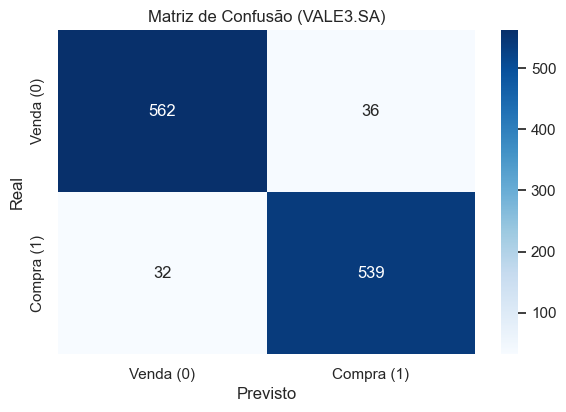


--- Relatório de Classificação (VALE3.SA) ---
              precision    recall  f1-score   support

   Venda (0)       0.95      0.94      0.94       598
  Compra (1)       0.94      0.94      0.94       571

    accuracy                           0.94      1169
   macro avg       0.94      0.94      0.94      1169
weighted avg       0.94      0.94      0.94      1169


--- AUC Score (VALE3.SA) ---
AUC Score (calculado): 0.9918


In [12]:
# Verifica se o modelo e os dados de teste existem
if 'model' in locals() and 'X_test_seq' in locals() and 'y_test_seq' in locals():
    print(f"Avaliando o modelo treinado ({STOCK_TICKER}) no conjunto de teste...")
    results = model.evaluate(X_test_seq, y_test_seq, verbose=0, batch_size=BATCH_SIZE*2 if 'BATCH_SIZE' in locals() else 128)
    loss = results[0]; accuracy = results[1]; auc_metric = results[2]

    print(f"\n--- Resultados da Avaliação {STOCK_TICKER} (evaluate) ---")
    print(f"Perda (Loss): {loss:.4f}")
    print(f"Acurácia: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"AUC (da evaluate): {auc_metric:.4f}")

    # Gera previsões
    print(f"\nGerando previsões {STOCK_TICKER}...")
    y_pred_proba = model.predict(X_test_seq, batch_size=BATCH_SIZE*2 if 'BATCH_SIZE' in locals() else 128, verbose=0).flatten()
    threshold = 0.5
    y_pred = (y_pred_proba >= threshold).astype(int)
    print(f"Usando limiar padrão: {threshold:.2f}")

    # Dataframe para plotagem (verifica se df_test e y_test_indices existem)
    if 'df_test' in locals() and 'y_test_indices' in locals():
         results_df = pd.DataFrame({'Actual': y_test_seq, 'Predicted': y_pred, 'Probability': y_pred_proba}, index=y_test_indices)
         # Verifica se o índice está contido em df_test antes de localizar
         valid_indices = results_df.index.intersection(df_test.index)
         if not valid_indices.empty:
             plot_df = df_test.loc[valid_indices].copy().join(results_df.loc[valid_indices])
         else:
             plot_df = None
             print("Aviso: Não foi possível alinhar previsões com dados de teste para plotagem.")
    else:
        plot_df = None
        print("Aviso: df_test ou y_test_indices não definidos. Gráfico de preço vs. predição não será gerado.")


    # Métricas Sklearn
    print(f"\n--- Matriz de Confusão ({STOCK_TICKER}) ---")
    cm = confusion_matrix(y_test_seq, y_pred)
    target_names_clf = ['Venda (0)', 'Compra (1)']
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names_clf, yticklabels=target_names_clf)
    plt.xlabel('Previsto'); plt.ylabel('Real'); plt.title(f'Matriz de Confusão ({STOCK_TICKER})')
    plt.show()

    print(f"\n--- Relatório de Classificação ({STOCK_TICKER}) ---")
    report = classification_report(y_test_seq, y_pred, target_names=target_names_clf, zero_division=0); print(report)
    print(f"\n--- AUC Score ({STOCK_TICKER}) ---")
    try:
        roc_auc_score_val = roc_auc_score(y_test_seq, y_pred_proba)
        print(f"AUC Score (calculado): {roc_auc_score_val:.4f}")
    except ValueError as e: print(f"Não foi possível calcular AUC score: {e}")
    except Exception as e: print(f"Erro ao calcular AUC Score: {e}")
else:
    print("\nModelo ou dados de teste não definidos. Avaliação não realizada.")


## 11. Visualização dos Resultados - VALE3.SA

Visualização do histórico de treinamento, curva ROC e gráfico de preço vs. previsões para o modelo VALE3.SA.


Gerando gráficos de visualização para VALE3.SA...
Plotando histórico de treinamento...


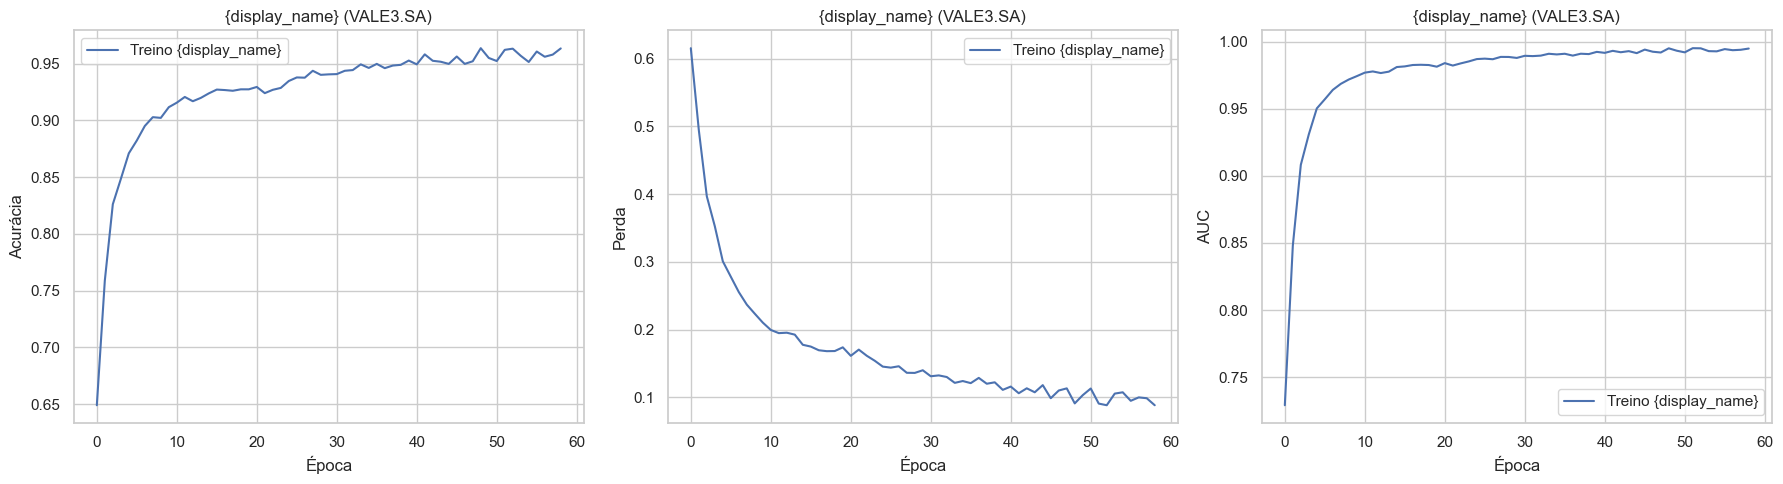

Plotando Curva ROC...


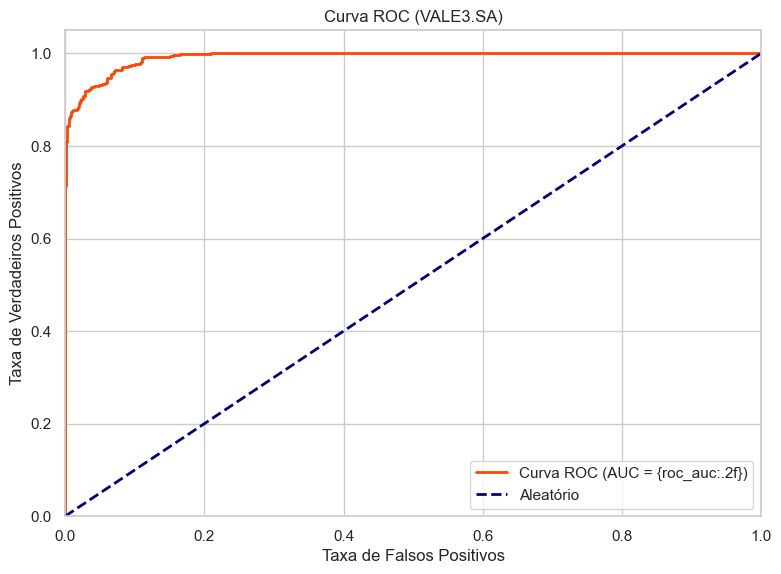

Plotando distribuição das probabilidades...


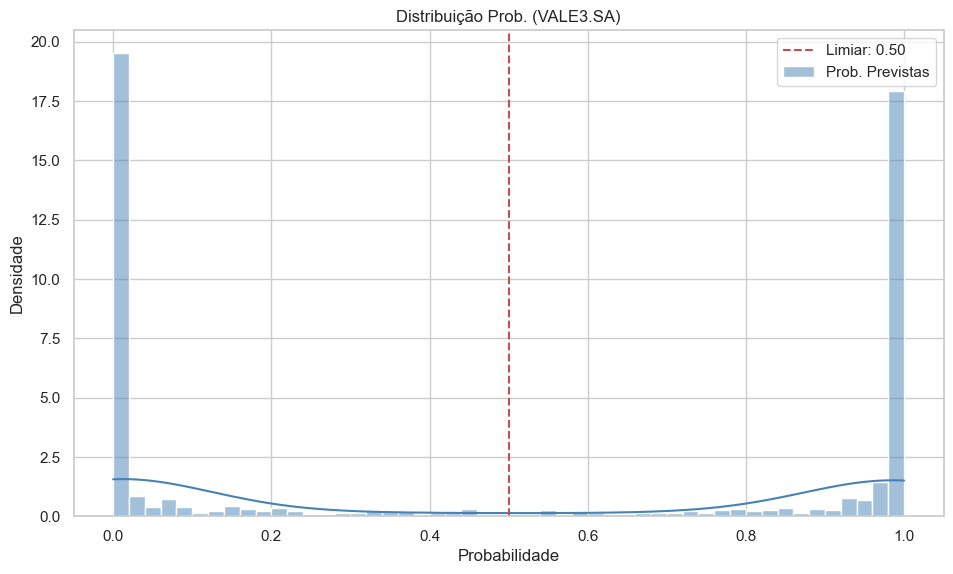

Plotando gráfico de Preço vs. Sinais Previstos (VALE3.SA)...


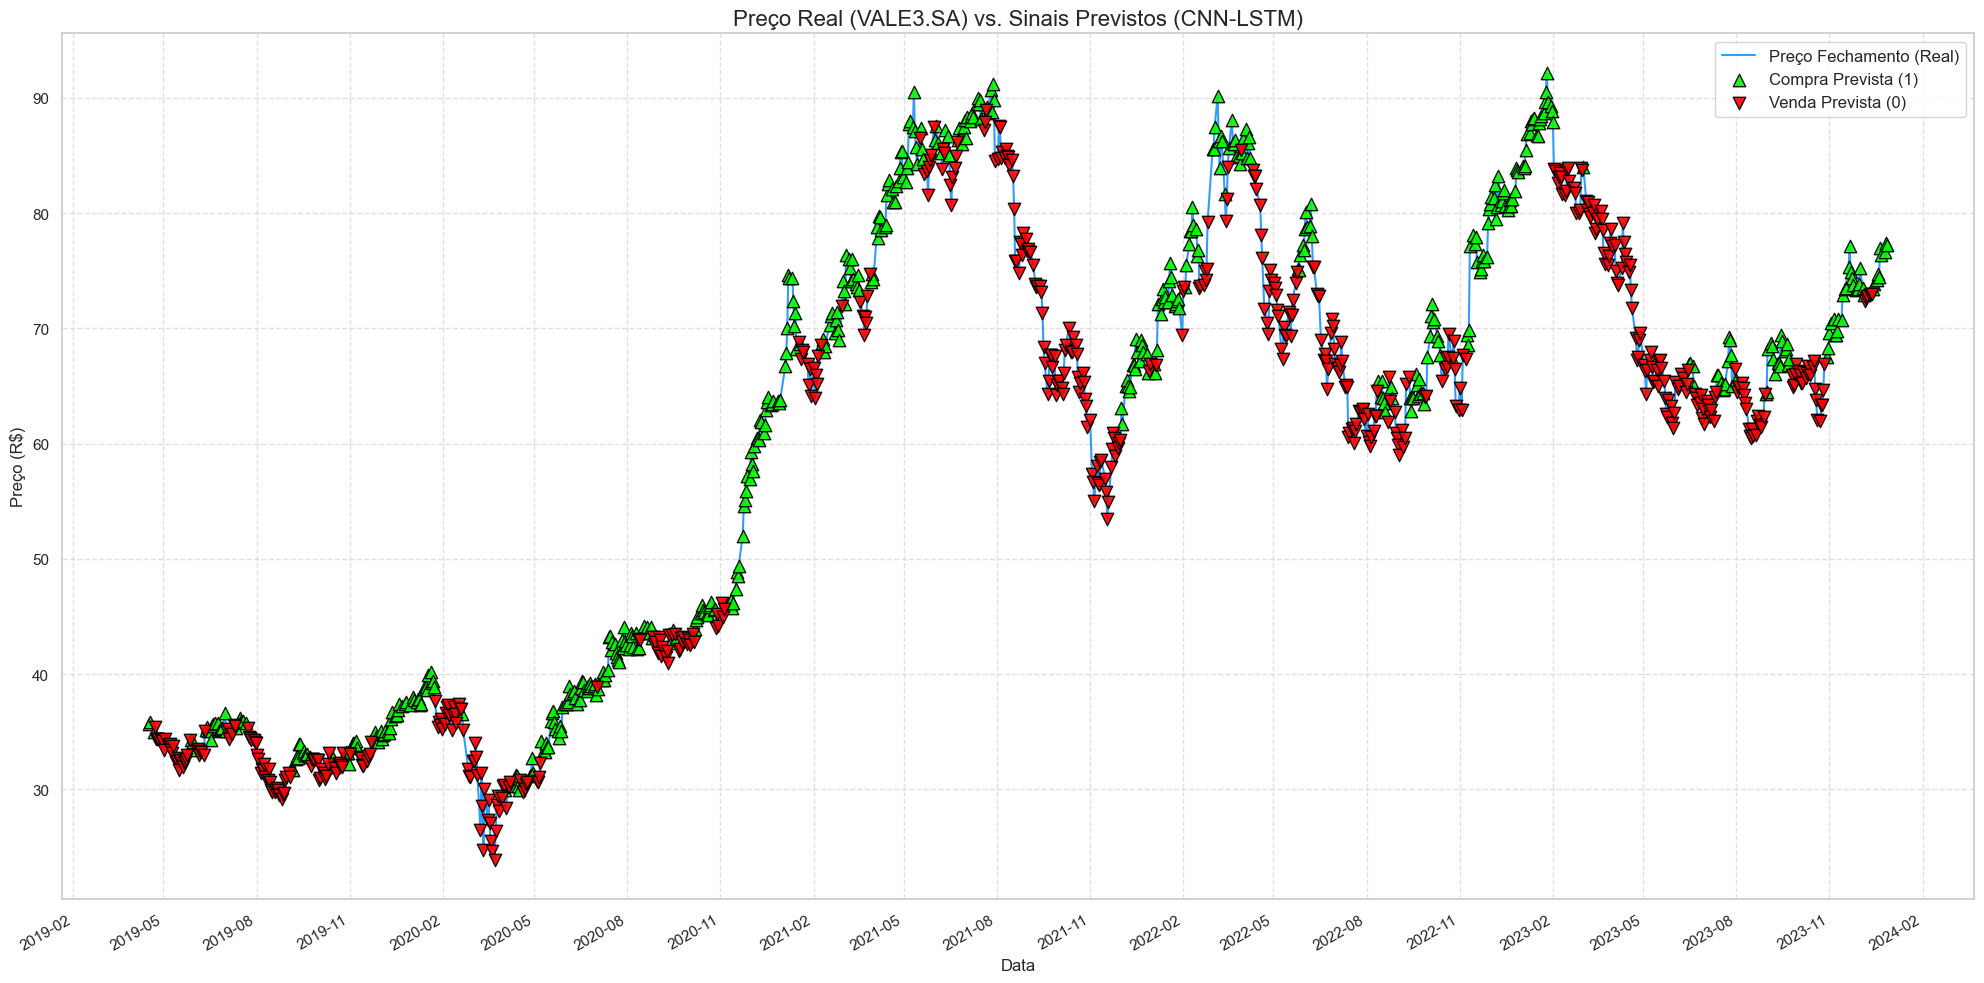

In [13]:
print(f"Gerando gráficos de visualização para {STOCK_TICKER}...")

# 1. Gráficos do Histórico de Treinamento
if 'history' in locals() and history is not None and history.history:
    print("Plotando histórico de treinamento...")
    plt.figure(figsize=(18, 5))
    metrics_to_plot={'Acurácia':'accuracy','Perda':'loss','AUC':'auc'}
    i=1
    for display_name, metric_key in metrics_to_plot.items():
        if metric_key in history.history:
            plt.subplot(1,len(metrics_to_plot), i)
            plt.plot(history.history[metric_key],label=f'Treino {{display_name}}')
            val_metric_key=f'val_{{metric_key}}'
            if val_metric_key in history.history:
                plt.plot(history.history[val_metric_key],label=f'Validação {{display_name}}')
            plt.title(f'{{display_name}} ({STOCK_TICKER})'); plt.xlabel('Época'); plt.ylabel(display_name); plt.legend(); i+=1
    plt.tight_layout(); plt.savefig(f'cnn_lstm_{STOCK_TICKER.replace(".SA","")}_training_metrics.png'); plt.show()
else: print("Histórico de treinamento não disponível.")

# 2. Gráfico da Curva ROC
if 'y_test_seq' in locals() and 'y_pred_proba' in locals() and len(np.unique(y_test_seq)) > 1:
    print("Plotando Curva ROC...")
    plt.figure(figsize=(8, 6))
    try:
        fpr, tpr, _ = roc_curve(y_test_seq, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='orangered', lw=2, label=f'Curva ROC (AUC = {{roc_auc:.2f}})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório')
        plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05]); plt.xlabel('Taxa de Falsos Positivos'); plt.ylabel('Taxa de Verdadeiros Positivos')
        plt.title(f'Curva ROC ({STOCK_TICKER})'); plt.legend(loc="lower right"); plt.grid(True); plt.savefig(f'cnn_lstm_{STOCK_TICKER.replace(".SA","")}_roc_curve.png'); plt.show()
    except Exception as e: print(f"Erro ao gerar curva ROC: {{e}}")
else: print("Curva ROC não gerada (dados insuficientes ou erro).")

# 3. Gráfico da Distribuição das Probabilidades
if 'y_pred_proba' in locals():
    print("Plotando distribuição das probabilidades...")
    plt.figure(figsize=(10, 6))
    sns.histplot(y_pred_proba, bins=50, kde=True, label='Prob. Previstas', color='steelblue', stat='density')
    plt.axvline(x=0.5, color='r', linestyle='--', label=f'Limiar: 0.50'); plt.title(f'Distribuição Prob. ({STOCK_TICKER})')
    plt.xlabel('Probabilidade'); plt.ylabel('Densidade'); plt.legend(); plt.savefig(f'cnn_lstm_{STOCK_TICKER.replace(".SA","")}_prediction_distribution.png'); plt.show()
else:
    print("Previsões não disponíveis para plotar distribuição.")


# 4. Gráfico de Preço Real vs. Sinais Previstos
if 'plot_df' in locals() and plot_df is not None and not plot_df.empty:
    print(f"Plotando gráfico de Preço vs. Sinais Previstos ({STOCK_TICKER})...")
    plt.figure(figsize=(20, 10))
    plt.plot(plot_df.index, plot_df['Close'], label='Preço Fechamento (Real)', color='dodgerblue', alpha=0.9, lw=1.5, zorder=1)
    buy_sig = plot_df[plot_df['Predicted'] == 1]; sell_sig = plot_df[plot_df['Predicted'] == 0]
    plt.scatter(buy_sig.index, buy_sig['Close'], label='Compra Prevista (1)', marker='^', color='lime', s=80, ec='black', alpha=0.9, zorder=3)
    plt.scatter(sell_sig.index, sell_sig['Close'], label='Venda Prevista (0)', marker='v', color='red', s=80, ec='black', alpha=0.9, zorder=3)
    plt.title(f'Preço Real ({STOCK_TICKER}) vs. Sinais Previstos (CNN-LSTM)', fontsize=16); plt.xlabel('Data', fontsize=12); plt.ylabel('Preço (R$)', fontsize=12)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')); plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gcf().autofmt_xdate(); plt.legend(fontsize=12); plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout()
    plt.savefig(f'cnn_lstm_{STOCK_TICKER.replace(".SA","")}_price_vs_predictions.png'); plt.show()
else:
    print("DataFrame para plotagem de preço vs. sinais não disponível.")


## 12. Salvamento do Modelo - VALE3.SA

Salvamos o modelo CNN-LSTM treinado para VALE3.SA.


In [14]:
# Converte nome para usar traço
STOCK_TICKER_DASH = STOCK_TICKER.replace('.', '_')
# Verifica se o modelo existe antes de salvar
if 'model' in locals():
    print(f"Salvando o modelo treinado para {STOCK_TICKER_DASH}...")
    MODEL_FILENAME = f"{STOCK_TICKER_DASH}_cnn_lstm_model.keras" # Nome dinâmico
    MODEL_SAVE_PATH = os.path.join('models', MODEL_FILENAME)
    H5_SAVE_PATH = MODEL_SAVE_PATH.replace('.keras', '.h5') # Fallback H5

    try:
        os.makedirs('models', exist_ok=True)
        model.save(MODEL_SAVE_PATH)
        print(f"Modelo salvo com sucesso em '{MODEL_SAVE_PATH}'")
        # Salvar HPs usados neste notebook
        final_hps = {
            'N_FILTERS': N_FILTERS, 'KERNEL_SIZE': KERNEL_SIZE, 'POOL_SIZE': POOL_SIZE,
            'LSTM_UNITS': LSTM_UNITS, 'DROPOUT_RATE': DROPOUT_RATE, 'LEARNING_RATE': LEARNING_RATE
        }
        hp_filename = f"cnn_lstm_{STOCK_TICKER_DASH}_final_hps.txt"
        with open(os.path.join('models', hp_filename), 'w') as f:
            for hp_name, hp_value in final_hps.items():
                f.write(f"{hp_name}: {hp_value}\n")
        print(f"Hiperparâmetros usados salvos em 'models/{hp_filename}'")

    except Exception as e:
        print(f"Erro ao salvar o modelo: {e}")
        try:
            model.save(H5_SAVE_PATH)
            print(f"Modelo salvo no formato HDF5 em '{H5_SAVE_PATH}'")
        except Exception as e2:
            print(f"Erro ao salvar o modelo no formato HDF5: {e2}")
else:
    print("\nModelo não definido. Nenhum modelo foi salvo.")

Salvando o modelo treinado para VALE3_SA...
Modelo salvo com sucesso em 'models/VALE3_SA_cnn_lstm_model.keras'
Hiperparâmetros usados salvos em 'models/cnn_lstm_VALE3_SA_final_hps.txt'
